# Use IMPA for unseen drug prediction BBBC021 

Import libraries 

In [1]:
# Standard library imports
import os
from pathlib import Path

# Third-party library imports
from tutorial_utils import t2np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import yaml 
import torch
from omegaconf import OmegaConf
from tqdm import tqdm

# Local application/library imports
from IMPA.dataset.data_loader import CellDataLoader
from IMPA.solver import IMPAmodule

Utils functions

In [2]:
def transform_by_emb(solver, dataloader, y, n_average, args):
    """
    Transform images in a dataloader using a solver for a specific drug ID.

    Parameters:
        solver: The solver object used for transformation.
        dataloader: The dataloader containing images to be transformed.
        n_average (int): Number of times to average random noise vectors.
        drug_id (str): The ID of the drug for transformation.
        args: Arguments object containing additional parameters.

    Returns:
        tuple: A tuple containing two NumPy arrays representing controls and transformed images.
    """
    controls = []
    transformed = []
    
    y = y.unsqueeze(0)
    with torch.no_grad():
        for batch in tqdm(dataloader.train_dataloader()):
            X_ctr = batch["X"][0]
            z = torch.ones(X_ctr.shape[0], n_average, args.z_dimension).cuda().mean(1)
            
            # Perturbation ID 
            y_emb = y.repeat((z.shape[0], 1)).cuda()
            y_emb = torch.cat([y_emb, z], dim=1)
            y_emb = solver.nets.mapping_network(y_emb) 
            
            _, X_generated = solver.nets.generator(X_ctr, y_emb)
            transformed.append(t2np(X_generated.detach().cpu(), batch_dim=True))
            controls.append(t2np(X_ctr.detach().cpu(), batch_dim=True))
            break
    return np.concatenate(controls, axis=0), np.concatenate(transformed, axis=0)

Read the configuration of interest

In [3]:
path_to_config = "../config_hydra/config/bbbc021_all.yaml"

In [4]:
# Reading the YAML file
with open(path_to_config, 'r') as file:
    config = yaml.safe_load(file)  # Use safe_load to avoid executing arbitrary code

# Access the loaded data
print(config)

{'task_name': 'bbbc021_all', 'img_size': 128, 'latent_dim': 1024, 'hidden_dim': 512, 'style_dim': 64, 'stochastic': True, 'z_dimension': 8, 'dim_in': 64, 'lambda_reg': 1, 'lambda_cyc': 1, 'lambda_sty': 1, 'lambda_ds': 1, 'total_epochs': 200, 'ds_iter': 100000, 'resume_iter': 0, 'batch_size': 16, 'val_batch_size': 8, 'lr': 0.0001, 'f_lr': 0.0001, 'beta1': 0, 'beta2': 0.99, 'weight_decay': 0.0001, 'num_outs_per_domain': 10, 'single_style': True, 'ood_set': ['taxol', 'ALLN', 'bryostatin', 'simvastatin', 'MG-132', 'methotrexate', 'colchicine', 'cytochalasin B', 'AZ258', 'cisplatin'], 'mol_list': None, 'balanced': False, 'trainable_emb': False, 'dataset_name': 'bbbc021', 'n_channels': 3, 'num_workers': 6, 'seed': 42, 'multimodal': False, 'batch_correction': False, 'batch_key': None, 'use_condition_embeddings': False, 'add_controls': False, 'condition_embedding_dimension': None, 'n_mod': 1, 'modality_list': ['Compound'], 'image_path': 'project_folder/datasets/bbbc021_unannotated_large', 'dat

In [5]:
config["image_path"] = "../" + config["image_path"]
config["data_index_path"] = "../" + config["data_index_path"]
config["embedding_path"] = "../" + config["embedding_path"]

Create an omega config dict

In [6]:
args = OmegaConf.create(config)

#### Initialize data loader

In [7]:
dataloader = CellDataLoader(args)

['transform_cells_bbbc021_six_drugs.ipynb', 'transform_cells_cpg0000_batch_corr.ipynb', 'transform_cells_rxrx1_batch_corr.ipynb', '__pycache__', 'transform_cells_bbbc021_all_unseen_prediction.ipynb', '.ipynb_checkpoints', 'transform_cells_cpg0000_pert_prediction.ipynb', 'tutorial_utils.py']


In [8]:
train_dataloader = dataloader.train_dataloader()
val_dataloader = dataloader.val_dataloader()

#### Initialize model 

In [12]:
checkpoint_dir = "../checkpoints/bbbc021_all/"

In [14]:
solver = IMPAmodule(args, checkpoint_dir, dataloader)
solver._load_checkpoint(200)

Number of parameters in generator: 24318595
Number of parameters in style_encoder: 16164480
Number of parameters in discriminator: 14341784
Number of parameters in mapping_network: 66112
Initializing embedding_matrix...
Initializing generator...
Initializing style_encoder...
Initializing discriminator...
Initializing mapping_network...
IMPAmodule(
  (embedding_matrix): Embedding(88, 1024)
  (generator): DataParallel(
    (module): Generator(
      (from_rgb): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (encode): ModuleList(
        (0): ResBlk(
          (actv): LeakyReLU(negative_slope=0.2)
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
          (norm2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Fals

**Tranform controls to perturbed**

In [15]:
# Initilize empty dictionaries 
controls = []
transformed = {}

with torch.no_grad():
    for i, (drug, drug_id) in enumerate(dataloader.mol2id.items()):
        print(f"Transforming images for {drug}")
        transformed[drug] = []
        for j, batch in tqdm(enumerate(dataloader.train_dataloader())):
            X_ctr = batch["X"][0]
            # z original and z transported
            z = torch.randn(X_ctr.shape[0], 100, args.z_dimension).cuda().mean(1)
    
            # Perturbation ID 
            id_pert = dataloader.mol2id[drug] * torch.ones(X_ctr.shape[0]).long().cuda()
            y = solver.embedding_matrix(id_pert)
            y = torch.cat([y, z], dim=1)
            y = solver.nets.mapping_network(y)
    
            _, X_generated = solver.nets.generator(X_ctr, y)

            if i==0:
                controls.append(t2np(X_ctr.detach().cpu(), batch_dim=True))
            transformed[drug].append(t2np(X_generated.detach().cpu(), batch_dim=True))
            if j==3:
                break
            
controls = np.concatenate(controls, axis=0) 
transformed = {key: np.concatenate(val, axis=0) for key, val in transformed.items()}

Transforming images for 3,3'-diaminobenzidine


3it [00:22,  7.51s/it]


Transforming images for 5-fluorouracil


3it [00:01,  2.45it/s]


Transforming images for AG-1478


3it [00:01,  2.01it/s]


Transforming images for AZ138


3it [00:01,  1.73it/s]


Transforming images for AZ235


3it [00:00,  3.68it/s]


Transforming images for AZ701


3it [00:00,  3.45it/s]


Transforming images for AZ841


3it [00:00,  3.79it/s]


Transforming images for Cdk1 inhibitor III


3it [00:00,  3.56it/s]


Transforming images for Cdk1/2 inhibitor (NU6102)


3it [00:00,  3.07it/s]


Transforming images for H-7


3it [00:00,  3.29it/s]


Transforming images for ICI-182,780


3it [00:00,  3.11it/s]


Transforming images for LY-294002


3it [00:01,  2.65it/s]


Transforming images for PD-150606


3it [00:00,  3.77it/s]


Transforming images for PD-169316


3it [00:00,  4.14it/s]


Transforming images for PD-98059


3it [00:00,  4.09it/s]


Transforming images for PP-2


3it [00:00,  4.08it/s]


Transforming images for SB-202190


3it [00:01,  2.88it/s]


Transforming images for SB-203580


3it [00:00,  3.74it/s]


Transforming images for SP-600125


3it [00:00,  3.48it/s]


Transforming images for UO-126


3it [00:01,  2.97it/s]


Transforming images for Y-27632


3it [00:00,  3.65it/s]


Transforming images for acyclovir


3it [00:00,  3.72it/s]


Transforming images for aloisine A


3it [00:00,  3.71it/s]


Transforming images for alsterpaullone


3it [00:00,  3.63it/s]


Transforming images for anisomycin


3it [00:00,  4.27it/s]


Transforming images for aphidicolin


3it [00:03,  1.12s/it]


Transforming images for arabinofuranosylcytosine


3it [00:00,  3.38it/s]


Transforming images for atropine


3it [00:00,  3.17it/s]


Transforming images for bleomycin


3it [00:00,  3.27it/s]


Transforming images for bohemine


3it [00:00,  4.29it/s]


Transforming images for brefeldin A


3it [00:00,  3.66it/s]


Transforming images for calpain inhibitor 2 (ALLM)


3it [00:00,  4.72it/s]


Transforming images for calpeptin


3it [00:00,  4.50it/s]


Transforming images for camptothecin


3it [00:00,  4.10it/s]


Transforming images for carboplatin


3it [00:00,  4.15it/s]


Transforming images for caspase inhibitor 1 (ZVAD)


3it [00:00,  3.23it/s]


Transforming images for cathepsin inhibitor I


3it [00:00,  4.01it/s]


Transforming images for chlorambucil


3it [00:00,  4.64it/s]


Transforming images for chloramphenicol


3it [00:00,  4.88it/s]


Transforming images for cyclohexamide


3it [00:00,  4.62it/s]


Transforming images for cyclophosphamide


3it [00:00,  4.56it/s]


Transforming images for cytochalasin D


3it [00:00,  4.69it/s]


Transforming images for demecolcine


3it [00:00,  4.32it/s]


Transforming images for deoxymannojirimycin


3it [00:00,  5.32it/s]


Transforming images for deoxynojirimycin


3it [00:00,  4.67it/s]


Transforming images for docetaxel


3it [00:00,  4.85it/s]


Transforming images for doxorubicin


3it [00:00,  4.25it/s]


Transforming images for emetine


3it [00:00,  4.13it/s]


Transforming images for epothilone B


3it [00:00,  5.24it/s]


Transforming images for etoposide


3it [00:00,  5.12it/s]


Transforming images for filipin


3it [00:00,  3.95it/s]


Transforming images for floxuridine


3it [00:00,  5.67it/s]


Transforming images for forskolin


3it [00:01,  2.81it/s]


Transforming images for genistein


3it [00:00,  5.59it/s]


Transforming images for herbimycin A


3it [00:00,  5.66it/s]


Transforming images for hydroxyurea


3it [00:00,  5.22it/s]


Transforming images for indirubin monoxime


3it [00:00,  5.14it/s]


Transforming images for jasplakinolide


3it [00:00,  3.53it/s]


Transforming images for lactacystin


3it [00:00,  5.59it/s]


Transforming images for latrunculin B


3it [00:00,  6.05it/s]


Transforming images for leupeptin


3it [00:00,  5.25it/s]


Transforming images for methoxylamine


3it [00:00,  4.85it/s]


Transforming images for mevinolin/lovastatin


3it [00:01,  2.24it/s]


Transforming images for mitomycin C


3it [00:00,  5.05it/s]


Transforming images for mitoxantrone


3it [00:00,  6.14it/s]


Transforming images for monastrol


3it [00:00,  4.83it/s]


Transforming images for neomycin


3it [00:00,  6.10it/s]


Transforming images for nocodazole


3it [00:00,  5.32it/s]


Transforming images for nystatin


3it [00:00,  6.07it/s]


Transforming images for okadaic acid


3it [00:00,  5.62it/s]


Transforming images for olomoucine


3it [00:00,  6.26it/s]


Transforming images for podophyllotoxin


3it [00:00,  3.98it/s]


Transforming images for proteasome inhibitor I


3it [00:00,  5.30it/s]


Transforming images for puromycin


3it [00:00,  5.91it/s]


Transforming images for quercetin


3it [00:00,  4.29it/s]


Transforming images for raloxifene


3it [00:00,  3.56it/s]


Transforming images for rapamycin


3it [00:00,  5.25it/s]


Transforming images for roscovitine


3it [00:00,  4.67it/s]


Transforming images for sodium butyrate


3it [00:00,  6.15it/s]


Transforming images for sodium fluoride


3it [00:00,  6.15it/s]


Transforming images for staurosporine


3it [00:00,  6.00it/s]


Transforming images for taurocholate


3it [00:00,  5.72it/s]


Transforming images for temozolomide


3it [00:01,  2.49it/s]


Transforming images for trichostatin


3it [00:00,  5.44it/s]


Transforming images for tunicamycin


3it [00:00,  4.65it/s]


Transforming images for valproic acid


3it [00:00,  4.57it/s]


Transforming images for vinblastine


3it [00:00,  5.70it/s]


Transforming images for vincristine


3it [00:00,  5.39it/s]


Control 0


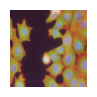

Control 1


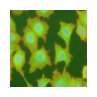

Control 2


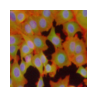

Control 3


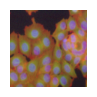

In [16]:
for i in range(len(controls)):
    print(f"Control {i}")
    plt.figure(figsize=(1, 1))
    plt.imshow(controls[i])
    plt.axis("off")
    plt.show()
    if i==3:
        break

Perturbation 3,3'-diaminobenzidine


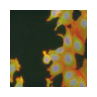

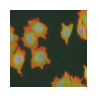

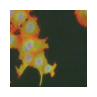

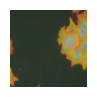

Perturbation 5-fluorouracil


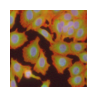

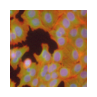

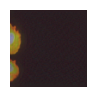

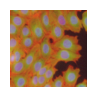

Perturbation AG-1478


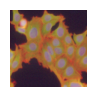

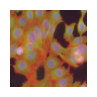

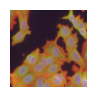

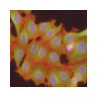

Perturbation AZ138


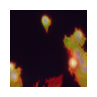

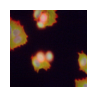

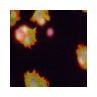

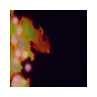

Perturbation AZ235


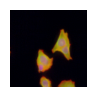

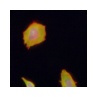

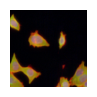

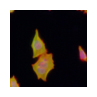

Perturbation AZ701


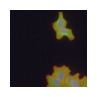

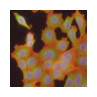

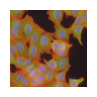

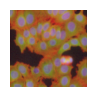

Perturbation AZ841


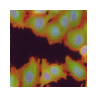

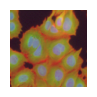

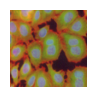

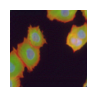

Perturbation Cdk1 inhibitor III


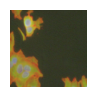

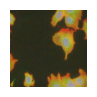

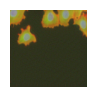

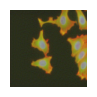

Perturbation Cdk1/2 inhibitor (NU6102)


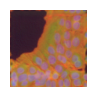

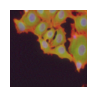

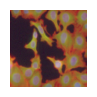

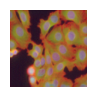

Perturbation H-7


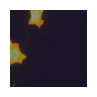

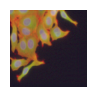

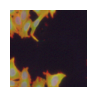

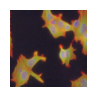

Perturbation ICI-182,780


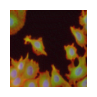

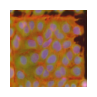

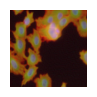

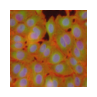

Perturbation LY-294002


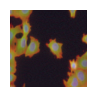

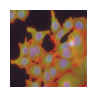

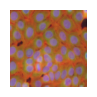

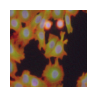

Perturbation PD-150606


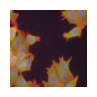

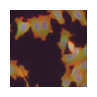

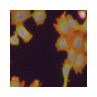

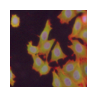

Perturbation PD-169316


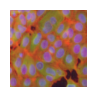

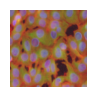

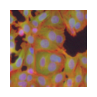

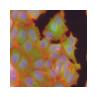

Perturbation PD-98059


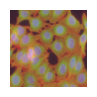

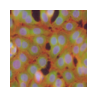

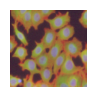

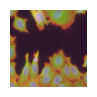

Perturbation PP-2


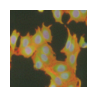

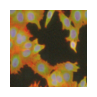

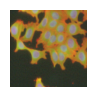

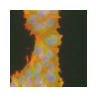

Perturbation SB-202190


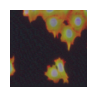

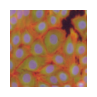

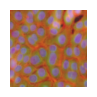

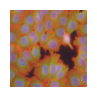

Perturbation SB-203580


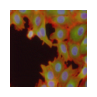

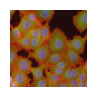

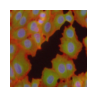

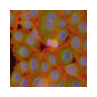

Perturbation SP-600125


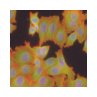

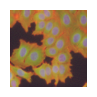

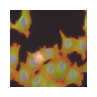

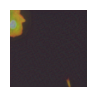

Perturbation UO-126


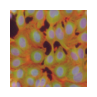

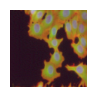

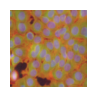

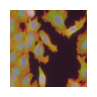

Perturbation Y-27632


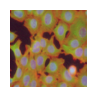

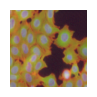

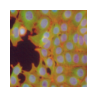

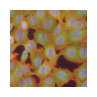

Perturbation acyclovir


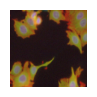

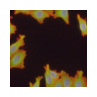

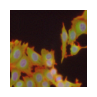

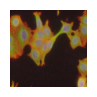

Perturbation aloisine A


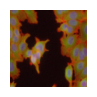

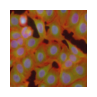

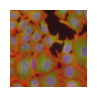

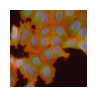

Perturbation alsterpaullone


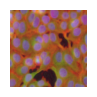

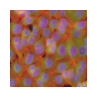

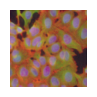

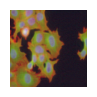

Perturbation anisomycin


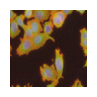

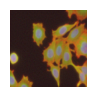

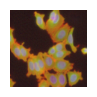

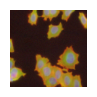

Perturbation aphidicolin


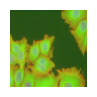

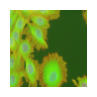

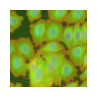

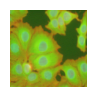

Perturbation arabinofuranosylcytosine


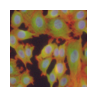

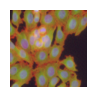

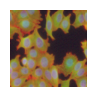

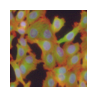

Perturbation atropine


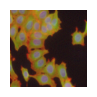

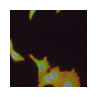

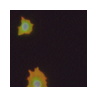

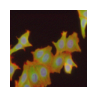

Perturbation bleomycin


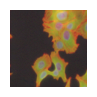

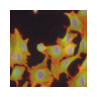

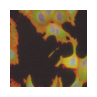

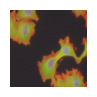

Perturbation bohemine


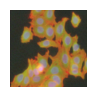

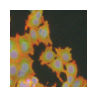

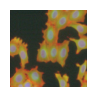

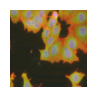

Perturbation brefeldin A


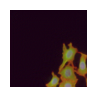

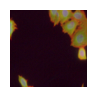

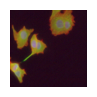

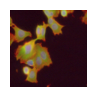

Perturbation calpain inhibitor 2 (ALLM)


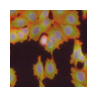

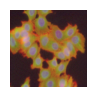

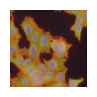

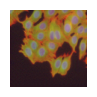

Perturbation calpeptin


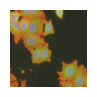

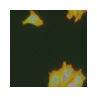

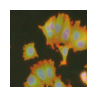

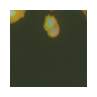

Perturbation camptothecin


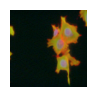

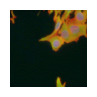

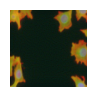

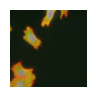

Perturbation carboplatin


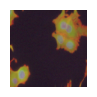

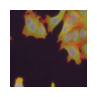

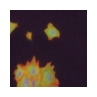

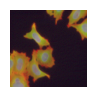

Perturbation caspase inhibitor 1 (ZVAD)


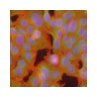

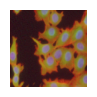

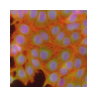

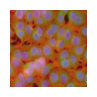

Perturbation cathepsin inhibitor I


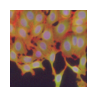

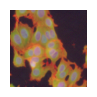

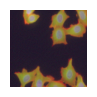

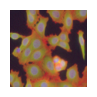

Perturbation chlorambucil


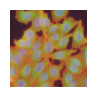

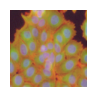

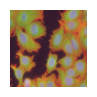

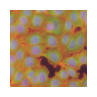

Perturbation chloramphenicol


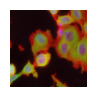

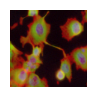

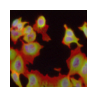

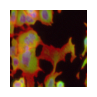

Perturbation cyclohexamide


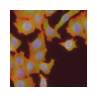

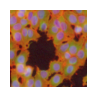

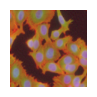

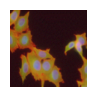

Perturbation cyclophosphamide


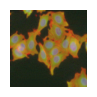

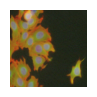

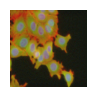

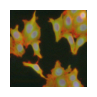

Perturbation cytochalasin D


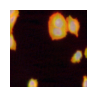

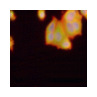

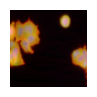

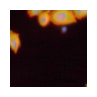

Perturbation demecolcine


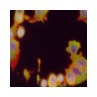

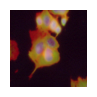

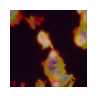

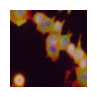

Perturbation deoxymannojirimycin


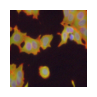

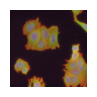

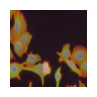

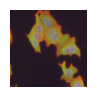

Perturbation deoxynojirimycin


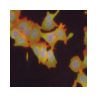

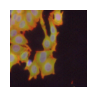

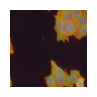

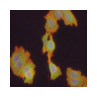

Perturbation docetaxel


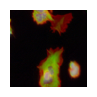

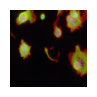

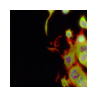

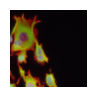

Perturbation doxorubicin


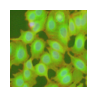

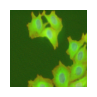

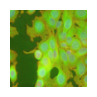

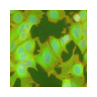

Perturbation emetine


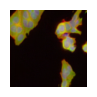

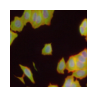

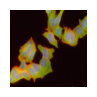

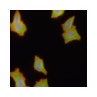

Perturbation epothilone B


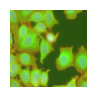

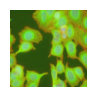

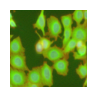

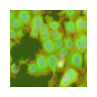

Perturbation etoposide


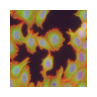

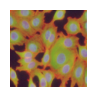

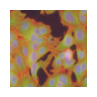

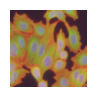

Perturbation filipin


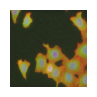

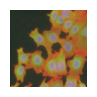

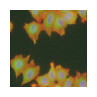

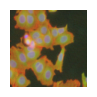

Perturbation floxuridine


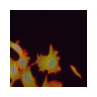

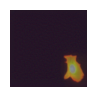

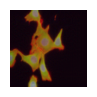

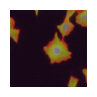

Perturbation forskolin


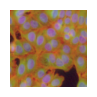

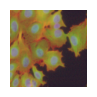

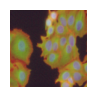

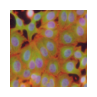

Perturbation genistein


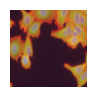

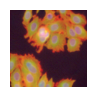

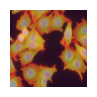

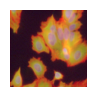

Perturbation herbimycin A


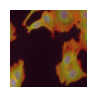

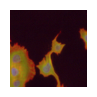

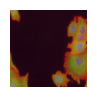

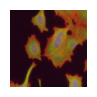

Perturbation hydroxyurea


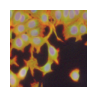

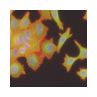

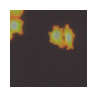

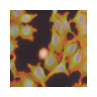

Perturbation indirubin monoxime


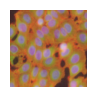

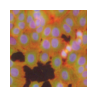

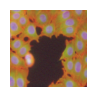

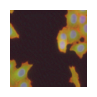

Perturbation jasplakinolide


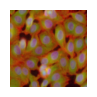

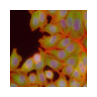

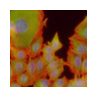

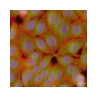

Perturbation lactacystin


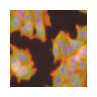

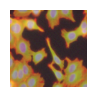

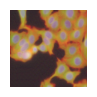

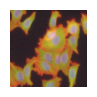

Perturbation latrunculin B


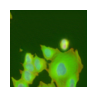

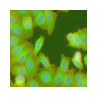

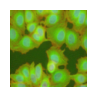

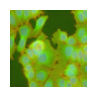

Perturbation leupeptin


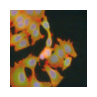

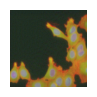

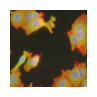

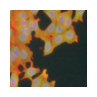

Perturbation methoxylamine


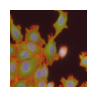

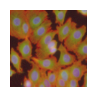

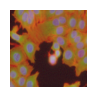

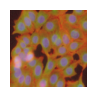

Perturbation mevinolin/lovastatin


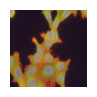

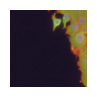

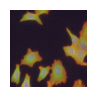

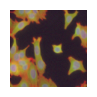

Perturbation mitomycin C


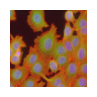

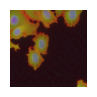

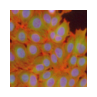

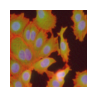

Perturbation mitoxantrone


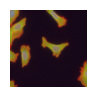

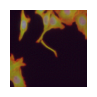

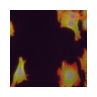

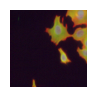

Perturbation monastrol


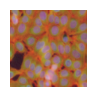

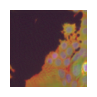

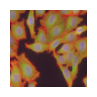

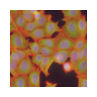

Perturbation neomycin


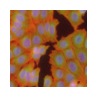

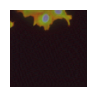

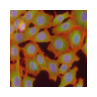

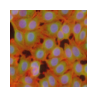

Perturbation nocodazole


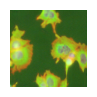

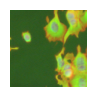

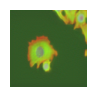

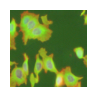

Perturbation nystatin


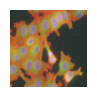

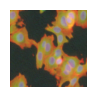

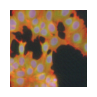

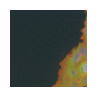

Perturbation okadaic acid


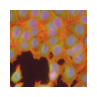

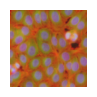

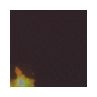

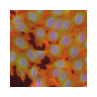

Perturbation olomoucine


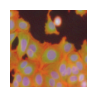

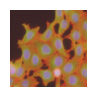

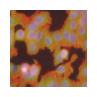

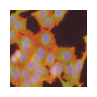

Perturbation podophyllotoxin


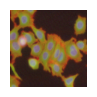

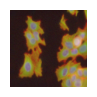

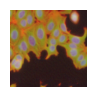

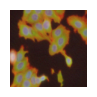

Perturbation proteasome inhibitor I


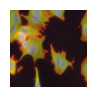

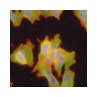

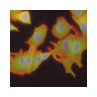

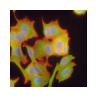

Perturbation puromycin


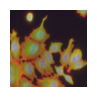

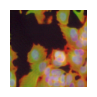

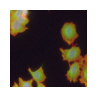

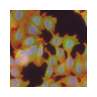

Perturbation quercetin


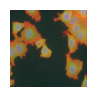

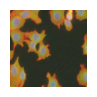

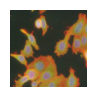

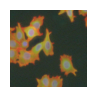

Perturbation raloxifene


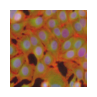

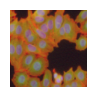

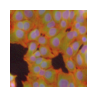

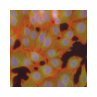

Perturbation rapamycin


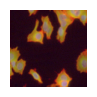

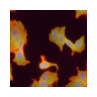

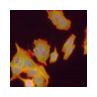

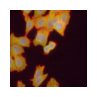

Perturbation roscovitine


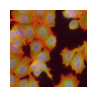

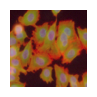

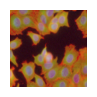

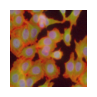

Perturbation sodium butyrate


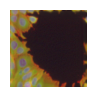

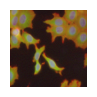

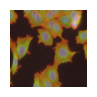

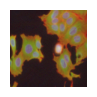

Perturbation sodium fluoride


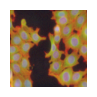

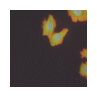

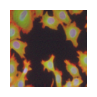

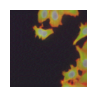

Perturbation staurosporine


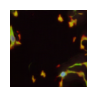

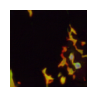

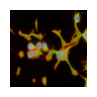

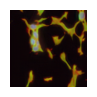

Perturbation taurocholate


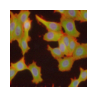

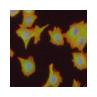

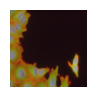

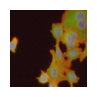

Perturbation temozolomide


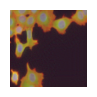

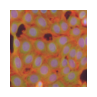

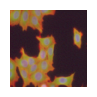

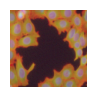

Perturbation trichostatin


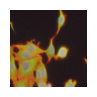

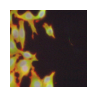

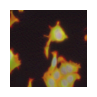

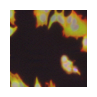

Perturbation tunicamycin


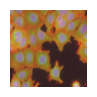

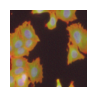

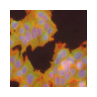

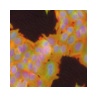

Perturbation valproic acid


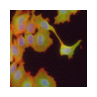

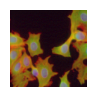

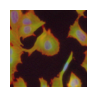

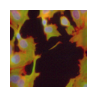

Perturbation vinblastine


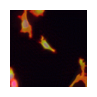

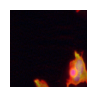

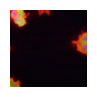

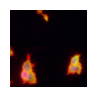

Perturbation vincristine


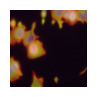

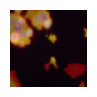

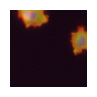

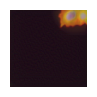

In [17]:
for pert in transformed:
    print(f"Perturbation {pert}")
    for i in range(len(transformed[pert])):
        plt.figure(figsize=(1, 1))
        plt.imshow(transformed[pert][i])
        plt.axis("off")
        plt.show()
        if i==3:
            break

**Predict on unseen perturbations**

In [18]:
ood_drugs = ["taxol", 
             "ALLN", 
             "bryostatin", 
             "simvastatin", 
             "MG-132", 
             "methotrexate", 
             "colchicine", 
             "cytochalasin B", 
             "AZ258", 
             "cisplatin"]

In [19]:
ood_drug_embeddings = pd.read_csv("../../IMPA/embeddings/csv/emb_fp_all.csv", index_col=0).loc[ood_drugs]

In [20]:
drugs = {}
controls = {}

for drug in ood_drugs:
    print(f"Transform into {drug}")
    emb_drug = torch.Tensor(ood_drug_embeddings.loc[drug])
    control, transformed = transform_by_emb(solver, dataloader, emb_drug, 100, args)
    drugs[drug] = transformed
    controls[drug] = control

Transform into taxol


  0%|          | 0/593 [00:01<?, ?it/s]


Transform into ALLN


  0%|          | 0/593 [00:01<?, ?it/s]


Transform into bryostatin


  0%|          | 0/593 [00:01<?, ?it/s]


Transform into simvastatin


  0%|          | 0/593 [00:01<?, ?it/s]


Transform into MG-132


  0%|          | 0/593 [00:01<?, ?it/s]


Transform into methotrexate


  0%|          | 0/593 [00:01<?, ?it/s]


Transform into colchicine


  0%|          | 0/593 [00:01<?, ?it/s]


Transform into cytochalasin B


  0%|          | 0/593 [00:01<?, ?it/s]


Transform into AZ258


  0%|          | 0/593 [00:01<?, ?it/s]


Transform into cisplatin


  0%|          | 0/593 [00:01<?, ?it/s]


Perturbation taxol


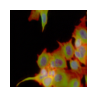

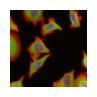

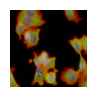

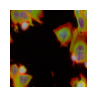

Perturbation ALLN


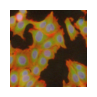

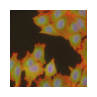

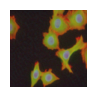

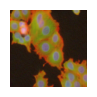

Perturbation bryostatin


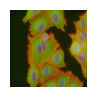

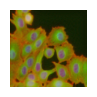

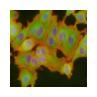

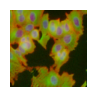

Perturbation simvastatin


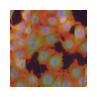

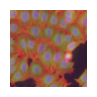

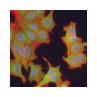

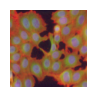

Perturbation MG-132


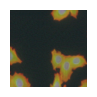

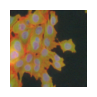

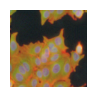

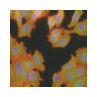

Perturbation methotrexate


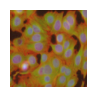

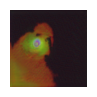

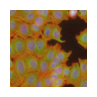

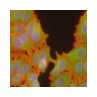

Perturbation colchicine


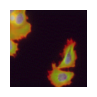

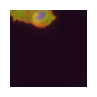

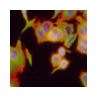

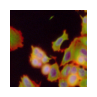

Perturbation cytochalasin B


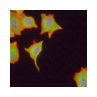

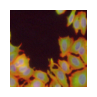

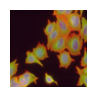

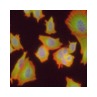

Perturbation AZ258


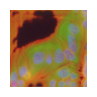

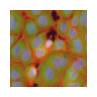

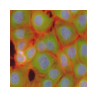

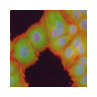

Perturbation cisplatin


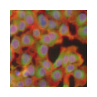

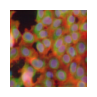

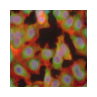

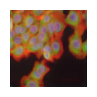

In [21]:
for pert in controls:
    print(f"Perturbation {pert}")
    for i in range(len(drugs[pert])):
        plt.figure(figsize=(1, 1))
        plt.imshow(drugs[pert][i])
        plt.axis("off")
        plt.show()
        if i==3:
            break